In [95]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import multiprocessing
plt.style.use('dark_background')
import pandas as pd
import re

In [9]:
filename = "../Domain/data/new_features.csv"

In [60]:
feature_df = pd.read_csv(filename)
features = feature_df.iloc[:, :-1]
labels = feature_df.iloc[:, -1]
feat_names = list(feature_df.columns[:-1])

In [101]:
f = 
f

<re.Match object; span=(0, 2), match='Re'>

In [127]:
# Delete region features
delete_key = 'Reg'
selected_features = [k for k, f in enumerate(feat_names) if not re.search(delete_key.lower(), str(f).lower())]

In [128]:
# index using selected features
features = feature_df.iloc[:, :-1].values
features = features[:, selected_features]

labels = feature_df.iloc[:, -1]

feat_names = list(feature_df.columns[:-1])
feat_names = np.array(feat_names)[selected_features]

In [129]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([31738,  8717]))

In [130]:
x_feat = np.where(features<=0, -99, features)

In [131]:
missing = np.sum(np.where(x_feat == -99, 1, 0))
valid   = np.sum(np.where(x_feat != -99, 1, 0))

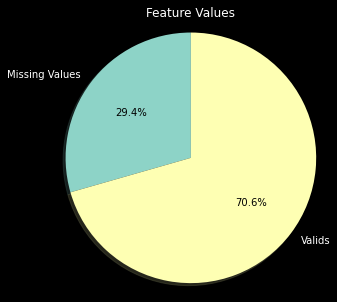

In [132]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels_tag = 'Missing Values', 'Valids'
sizes = [missing, valid]

fig1, ax1 = plt.subplots(figsize=(5,5))
_, _, autotexts = ax1.pie(sizes, labels=labels_tag, autopct='%1.1f%%',
        shadow=True, startangle=90)


for autotext in autotexts:
    autotext.set_color('Black')
    
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Feature Values')
plt.show()

In [133]:
%%time
parameters = {"n_estimators": [500, 1000, 2000], 
              "max_depth": [None], 
              "class_weight":["balanced_subsample"],
              "n_jobs":[multiprocessing.cpu_count()]}

clf = GridSearchCV(RandomForestClassifier(), parameters, cv=3)
clf.fit(x_feat, labels)

CPU times: user 1min 33s, sys: 4.53 s, total: 1min 38s
Wall time: 34.3 s


In [134]:
print('CV ACC: {:.2f} +- {:.2f}'.format(clf.cv_results_['mean_test_score'][0], 
                                        clf.cv_results_['std_test_score'][0]))

CV ACC: 0.71 +- 0.09


In [135]:
x_train, x_test, y_train, y_test = train_test_split(x_feat, labels, test_size=0.33, random_state=42)

In [136]:
model = RandomForestClassifier(n_estimators=clf.best_estimator_.n_estimators, 
                               max_depth=None, 
                               class_weight='balanced_subsample', 
                               n_jobs=multiprocessing.cpu_count())
model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=500,
                       n_jobs=96)

In [137]:
y_pred = model.predict(x_test)

In [138]:
precision, recall, f1, supp = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Precision:{:.2f}\nRecall:{:.2f}\nF1:{:.2f}'.format(precision, recall, f1))

Precision:0.99
Recall:0.98
F1:0.98


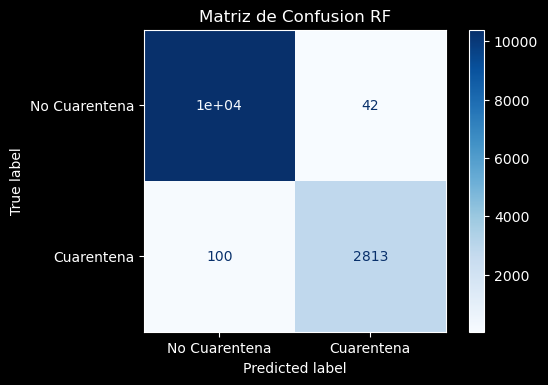

In [139]:
fig, ax = plt.subplots(1,1, dpi=100)
disp = plot_confusion_matrix(model, x_test, y_test,
                             display_labels=['No Cuarentena', 'Cuarentena'],
                             cmap=plt.cm.Blues,
                             normalize=None, ax=ax)
ax.set_title('Matriz de Confusion RF')
fig.savefig('./cm_nr.png', format='png')

In [140]:
len(model.feature_importances_)

72

In [141]:
sorted_indices = np.argsort(model.feature_importances_, )
importances   = model.feature_importances_[sorted_indices]#[::-1]
feature_names = np.array(feat_names)[sorted_indices]#[::-1]

In [142]:
feature_names_bold = [r'$\bf{'+x+'}$' if 'Comuna' in x else x for x in feature_names]

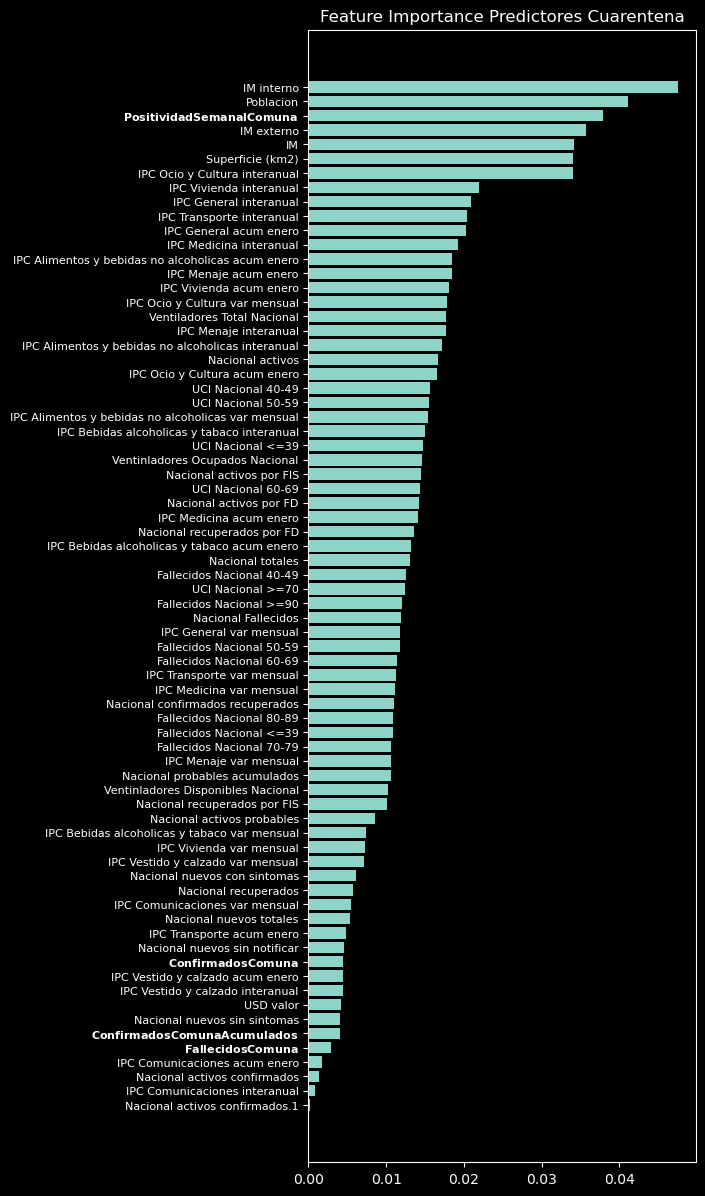

In [143]:
plt.figure(figsize=(5,15), dpi=100)
plt.barh(range(0, len(importances)), importances, align='center')
plt.yticks(range(0, len(importances)), feature_names_bold, rotation=0, fontsize=8)
plt.title('Feature Importance Predictores Cuarentena')
plt.savefig('./importance_nr.png', format='png', bbox_inches='tight')
plt.show()